In [124]:
import requests
import urllib3
import secrets
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [125]:
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

## Strava API Request

In [126]:
auth_url = 'https://www.strava.com/oauth/token'
activities_url = 'https://www.strava.com/api/v3/athlete/activities'

print('Requesting Strava token... \n')
res = requests.post(auth_url, data=secrets.strava_payload, verify=False)
strava_access_token = res.json()['access_token']

header = {'Authorization': 'Bearer ' + strava_access_token}

strava_requests_page_num = 1
all_activities = []

while True:
    strava_param = {'per_page' : 15, 'page' : strava_requests_page_num}
    strava_dataset = requests.get(activities_url, headers=header, params=strava_param).json()

    if len(strava_dataset) == 0:
        print('breaking out of Strava while loop because the response is zero, indicating no more activities.')
        break

    if all_activities:
        print('all activities is populated')
        all_activities.extend(strava_dataset)

    else:
        print('all activities is NOT populated')
        all_activities = strava_dataset

    strava_requests_page_num += 1

print('Total Activities: ', len(all_activities))

Requesting Strava token... 



all activities is NOT populated
all activities is populated
all activities is populated
all activities is populated
breaking out of Strava while loop because the response is zero, indicating no more activities.
Total Activities:  50


## Creating pandas dataframe for running data

In [127]:
run_data = pd.DataFrame(data=all_activities)

In [128]:
run_data.columns

Index(['resource_state', 'athlete', 'name', 'distance', 'moving_time',
       'elapsed_time', 'total_elevation_gain', 'type', 'sport_type',
       'workout_type', 'id', 'start_date', 'start_date_local', 'timezone',
       'utc_offset', 'location_city', 'location_state', 'location_country',
       'achievement_count', 'kudos_count', 'comment_count', 'athlete_count',
       'photo_count', 'map', 'trainer', 'commute', 'manual', 'private',
       'visibility', 'flagged', 'gear_id', 'start_latlng', 'end_latlng',
       'average_speed', 'max_speed', 'has_heartrate', 'heartrate_opt_out',
       'display_hide_heartrate_option', 'elev_high', 'elev_low', 'upload_id',
       'upload_id_str', 'external_id', 'from_accepted_tag', 'pr_count',
       'total_photo_count', 'has_kudoed', 'suffer_score', 'average_watts',
       'kilojoules', 'device_watts'],
      dtype='object')

In [129]:
run_data.head()

,resource_state,athlete,name,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,workout_type,...,upload_id_str,external_id,from_accepted_tag,pr_count,total_photo_count,has_kudoed,suffer_score,average_watts,kilojoules,device_watts
0,2,"{'id': 8586088, 'resource_state': 1}",PMRP : Hot Afternoon Run,7090.5,2341,2365,210.0,Run,Run,0.0,...,10124522361,0B1C68DC-4E71-4EBB-8217-F688A9582DCD-activity.fit,False,0,0,False,NaN,NaN,NaN,NaN
1,2,"{'id': 8586088, 'resource_state': 1}",Ten Sleep : French Cattle Ranch Approach,1594.6,1483,1483,186.4,Hike,Hike,NaN,...,10023599286,70EA4DF3-F218-4DB7-B818-E242D7EC3F45-activity.fit,False,0,0,False,NaN,NaN,NaN,NaN
2,2,"{'id': 8586088, 'resource_state': 1}",Ten Sleep : Approach to Downtown,471.3,625,656,90.8,Hike,Hike,NaN,...,10004892705,7A3018DD-C2AB-447C-AF8E-92D86CE6B16E-activity.fit,False,0,0,False,NaN,NaN,NaN,NaN
3,2,"{'id': 8586088, 'resource_state': 1}",Ten Sleep : Morning Run,2927.4,937,943,27.1,Run,Run,0.0,...,9970213520,D9326B4B-A20A-4FFC-963A-A75D2D17971D-activity.fit,False,0,0,False,NaN,NaN,NaN,NaN
4,2,"{'id': 8586088, 'resource_state': 1}",Ten Sleep : Morning Run,3801.4,1185,1327,61.0,Run,Run,0.0,...,9970213502,9E9E8812-BB6B-4016-96DA-8E72047B2967-activity.fit,False,2,0,False,NaN,NaN,NaN,NaN


In [130]:
columns_to_drop = ['athlete',
                   'resource_state', 
                   'sport_type', 
                   'workout_type',
                   'location_city',
                   'location_state',
                   'location_country', 
                   'kudos_count', 
                   'comment_count', 
                   'athlete_count', 
                   'photo_count', 
                   'trainer', 
                   'commute', 
                   'manual', 
                   'private',
                   'visibility', 
                   'flagged', 
                   'gear_id', 
                   'has_heartrate', 
                   'heartrate_opt_out', 
                   'display_hide_heartrate_option', 
                   'from_accepted_tag', 
                   'total_photo_count', 
                   'has_kudoed', 
                   'average_watts', 
                   'kilojoules',
                   'achievement_count',
                   'device_watts',
                   'upload_id_str',
                   'upload_id',
                   'external_id',
                   'id', 
                   'suffer_score']

run_data.drop(columns=columns_to_drop, inplace=True)

In [131]:
run_data.columns

Index(['name', 'distance', 'moving_time', 'elapsed_time',
       'total_elevation_gain', 'type', 'start_date', 'start_date_local',
       'timezone', 'utc_offset', 'map', 'start_latlng', 'end_latlng',
       'average_speed', 'max_speed', 'elev_high', 'elev_low', 'pr_count'],
      dtype='object')

In [132]:
run_data = run_data.loc[run_data['type'] == 'Run']
run_data

,name,distance,moving_time,elapsed_time,total_elevation_gain,type,start_date,start_date_local,timezone,utc_offset,map,start_latlng,end_latlng,average_speed,max_speed,elev_high,elev_low,pr_count
0,PMRP : Hot Afternoon Run,7090.5,2341,2365,210.0,Run,2023-07-12T20:20:42Z,2023-07-12T16:20:42Z,(GMT-05:00) America/New_York,-14400.0,"{'id': 'a9439898989', 'summary_polyline': 'inw...","[37.64469179324806, -83.71427628211677]","[37.64480469748378, -83.71436378918588]",3.029,13.532,348.9,259.0,0
3,Ten Sleep : Morning Run,2927.4,937,943,27.1,Run,2023-06-19T12:34:47Z,2023-06-19T06:34:47Z,(GMT-07:00) America/Denver,-21600.0,"{'id': 'a9294421659', 'summary_polyline': 'sn`...","[44.080588202923536, -107.31504295952618]","[44.07666949555278, -107.329665357247]",3.124,4.750,1655.9,1583.3,0
4,Ten Sleep : Morning Run,3801.4,1185,1327,61.0,Run,2023-06-17T12:57:06Z,2023-06-17T06:57:06Z,(GMT-07:00) America/Denver,-21600.0,"{'id': 'a9294421645', 'summary_polyline': '_w_...","[44.07680050469935, -107.32967047020793]","[44.07670805230737, -107.32964641414583]",3.208,6.196,1645.2,1583.4,2
5,RRG : Grays Arch Loop w/ Rush Trail,6222.5,2225,2271,173.6,Run,2023-05-31T15:42:37Z,2023-05-31T11:42:37Z,(GMT-05:00) America/New_York,-14400.0,"{'id': 'a9176575201', 'summary_polyline': 'ejw...","[37.80787202529609, -83.65785769186914]","[37.80757279135287, -83.65820646286011]",2.797,7.315,392.0,255.0,0
6,PMRP : Rain Run,8973.2,2836,2882,368.6,Run,2023-05-28T18:17:37Z,2023-05-28T14:17:37Z,(GMT-05:00) America/New_York,-14400.0,"{'id': 'a9159069458', 'summary_polyline': '{mw...","[37.64462482184172, -83.71412750333548]","[37.64463094063103, -83.7141434289515]",3.164,16.328,349.9,259.0,0
7,PMRP : Lode Loop and Lode Hill,2615.8,843,849,96.5,Run,2023-05-12T19:53:27Z,2023-05-12T15:53:27Z,(GMT-05:00) America/New_York,-14400.0,"{'id': 'a9059541871', 'summary_polyline': 'unw...","[37.64475432224572, -83.71380949392915]","[37.644639406353235, -83.71410939842463]",3.103,7.168,339.3,267.6,0
8,PMRP : Lode Loop and Flat Holler Loop,9653.3,3349,3385,453.1,Run,2023-05-05T18:39:29Z,2023-05-05T14:39:29Z,(GMT-05:00) America/New_York,-14400.0,"{'id': 'a9017048707', 'summary_polyline': 'kow...","[37.64486974105239, -83.71435523964465]","[37.644784580916166, -83.7140276748687]",2.882,14.712,332.0,259.2,1
10,PMRP : Drive By Loop and Lode Loop,5774.7,1769,1827,131.6,Run,2023-04-28T18:23:12Z,2023-04-28T14:23:12Z,(GMT-05:00) America/New_York,-14400.0,"{'id': 'a8973585450', 'summary_polyline': 'anw...","[37.644651057198644, -83.71401585638523]","[37.644623816013336, -83.7140057142824]",3.264,11.087,333.2,258.4,1
12,PMRP : Sore Heel Loop,6867.9,2329,2376,228.5,Run,2023-04-13T18:21:31Z,2023-04-13T14:21:31Z,(GMT-05:00) America/New_York,-14400.0,"{'id': 'a8885448119', 'summary_polyline': 'oqw...","[37.645207112655044, -83.71454006060958]","[37.644659858196974, -83.71419346891344]",2.949,13.132,333.6,259.0,0
13,RRG : Courthouse Loop,8248.8,3275,3344,279.2,Run,2023-04-12T20:59:26Z,2023-04-12T16:59:26Z,(GMT-05:00) America/New_York,-14400.0,"{'id': 'a8880411991', 'summary_polyline': 'yvy...","[37.820134749636054, -83.68102812208235]","[37.820320911705494, -83.68090356700122]",2.519,7.558,398.4,237.7,0


## Conversions for Metrics

In [133]:
run_data['distance_miles'] = round(run_data['distance'] * 0.00062137119, 2)
run_data['moving_time_minutes'] = round(run_data['moving_time'] / 60, 2)
run_data['moving_time_hours'] = round(run_data['moving_time'] / 3600, 2)

In [134]:
average_distance_miles = round(run_data['distance_miles'].mean(), 2)
print("Average Distance (miles):", average_distance_miles)

average_time_minutes = round(run_data['moving_time_minutes'].mean(), 2)
print("Average Time Ran (minutes):", average_time_minutes)

max_distance_ran = round(run_data['distance_miles'].max(), 2)
print("Longest Run:", max_distance_ran, "miles")

max_duration_mintues = round(run_data['moving_time_minutes'].max(), 2)
max_duration_hours = round(run_data['moving_time_hours'].max(), 2)
print("Longest Duration:", max_duration_mintues,"minutes. Converted to hours:", max_duration_hours)

total_distance_miles = round(run_data['distance'].sum() * 0.00062137119, 2)
print("Total Distance Covered to the date (miles):", total_distance_miles)

Average Distance (miles): 3.97
Average Time Ran (minutes): 40.64
Longest Run: 9.62 miles
Longest Duration: 117.57 minutes. Converted to hours: 1.96
Total Distance Covered to the date (miles): 134.89


Text(0, 0.5, 'Moving Time / Minutes')

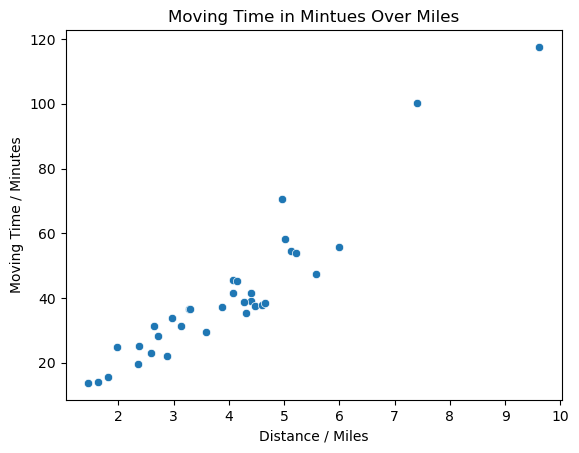

In [135]:
sns.scatterplot(data=run_data,
                x='distance_miles',
                y='moving_time_minutes')

plt.title('Moving Time in Mintues Over Miles')
plt.xlabel('Distance / Miles')
plt.ylabel('Moving Time / Minutes')

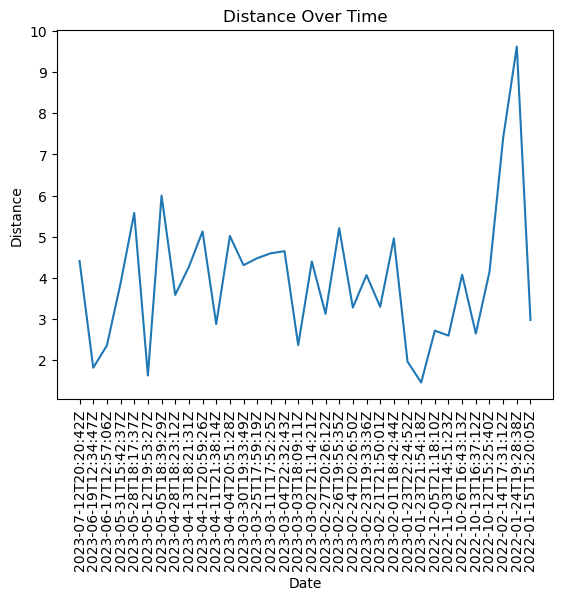

In [136]:
sns.lineplot(data=run_data,
            x= 'start_date',
            y='distance_miles')

plt.title('Distance Over Time')
plt.xlabel('Date')
plt.ylabel('Distance')
plt.xticks(rotation=90)
plt.show()

In [137]:
csv_path = 'csv/run_data.csv'
run_data.to_csv(csv_path, index=False)